In [1]:
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ROSMAP_PATH = 'ROSMAP_clinical.csv'
CT_COUNTS_META_PATH = 'ct_counts_public_meta.h5ad'

ROSMAP_data = pd.read_csv(ROSMAP_PATH)
ct_counts_metadata: ad.AnnData = ad.read_h5ad(CT_COUNTS_META_PATH)


In [2]:
ct_counts_metadata

AnnData object with n_obs × n_vars = 427 × 54
    obs: 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', 'individualID', 'projid'

In [3]:
# Remove outliers

from core.outliers import *

before_shape = ct_counts_metadata.shape
calculate_ct_per_median(ct_counts_metadata, 'Exc RELN CHD7', column_name='RELN_metric')
thresh = np.percentile(ct_counts_metadata.obs['RELN_metric'], 97)
print(thresh)
ct_counts_metadata = remove_outliers(ct_counts_metadata, 'RELN_metric', thresh)
after_shape = ct_counts_metadata.shape
assert before_shape != after_shape

158.76045454545275


/home/jacob/Documents/BEP/bsc-thesis-scripts/core/outliers.py:38: RuntimeWarning: invalid value encountered in scalar divide
  cpm = ct_count / avg_metric
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/outliers.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  cpm = ct_count / avg_metric


/home/jacob/Documents/BEP/bsc-thesis-scripts/plotmodules/norm_plots.py:114: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/annotate.py:16: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/tmp/ipykernel_121452/3522506972.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


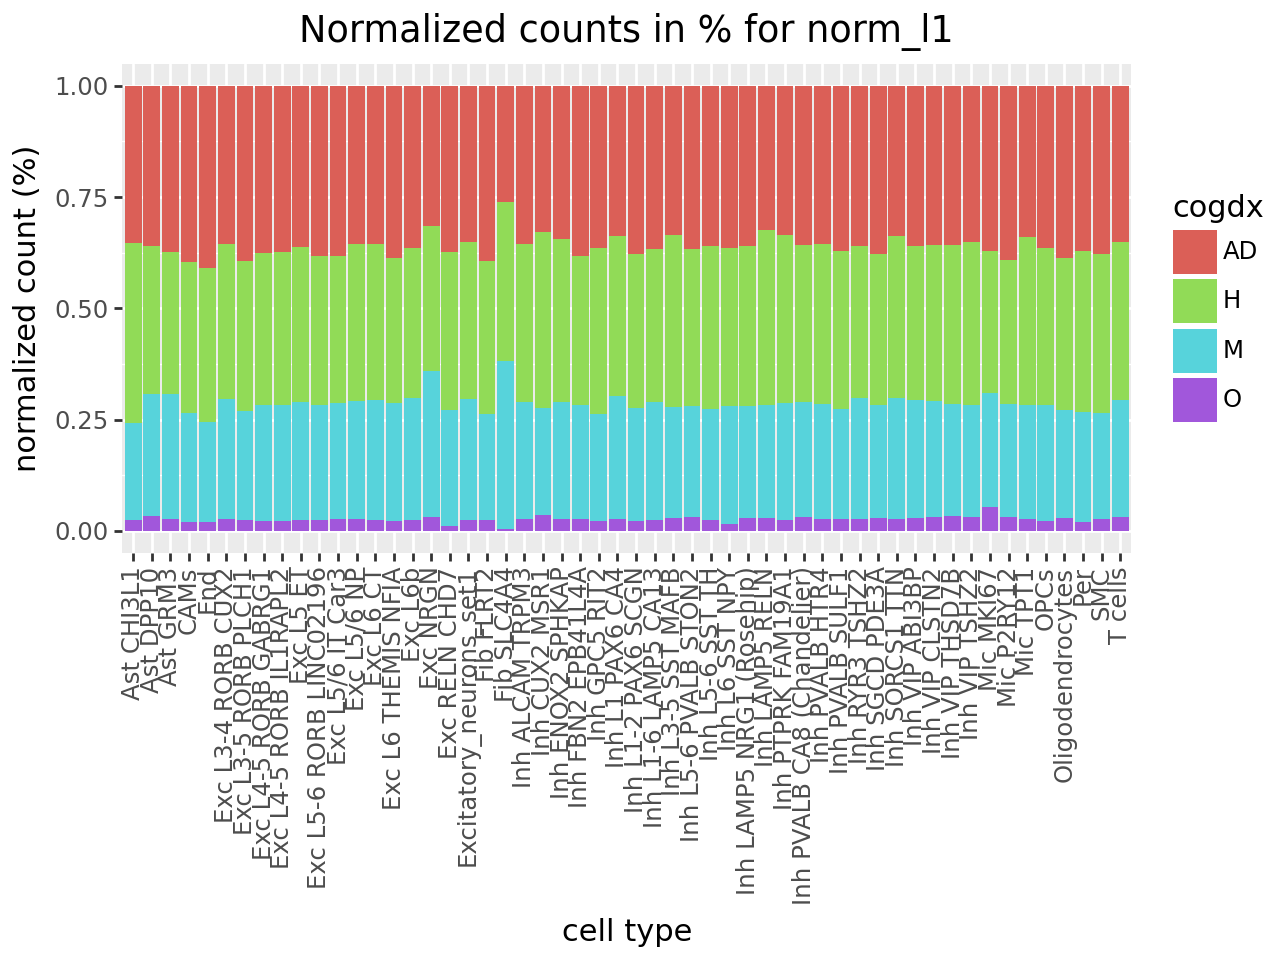

/home/jacob/Documents/BEP/bsc-thesis-scripts/plotmodules/norm_plots.py:114: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
/tmp/ipykernel_121452/3522506972.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


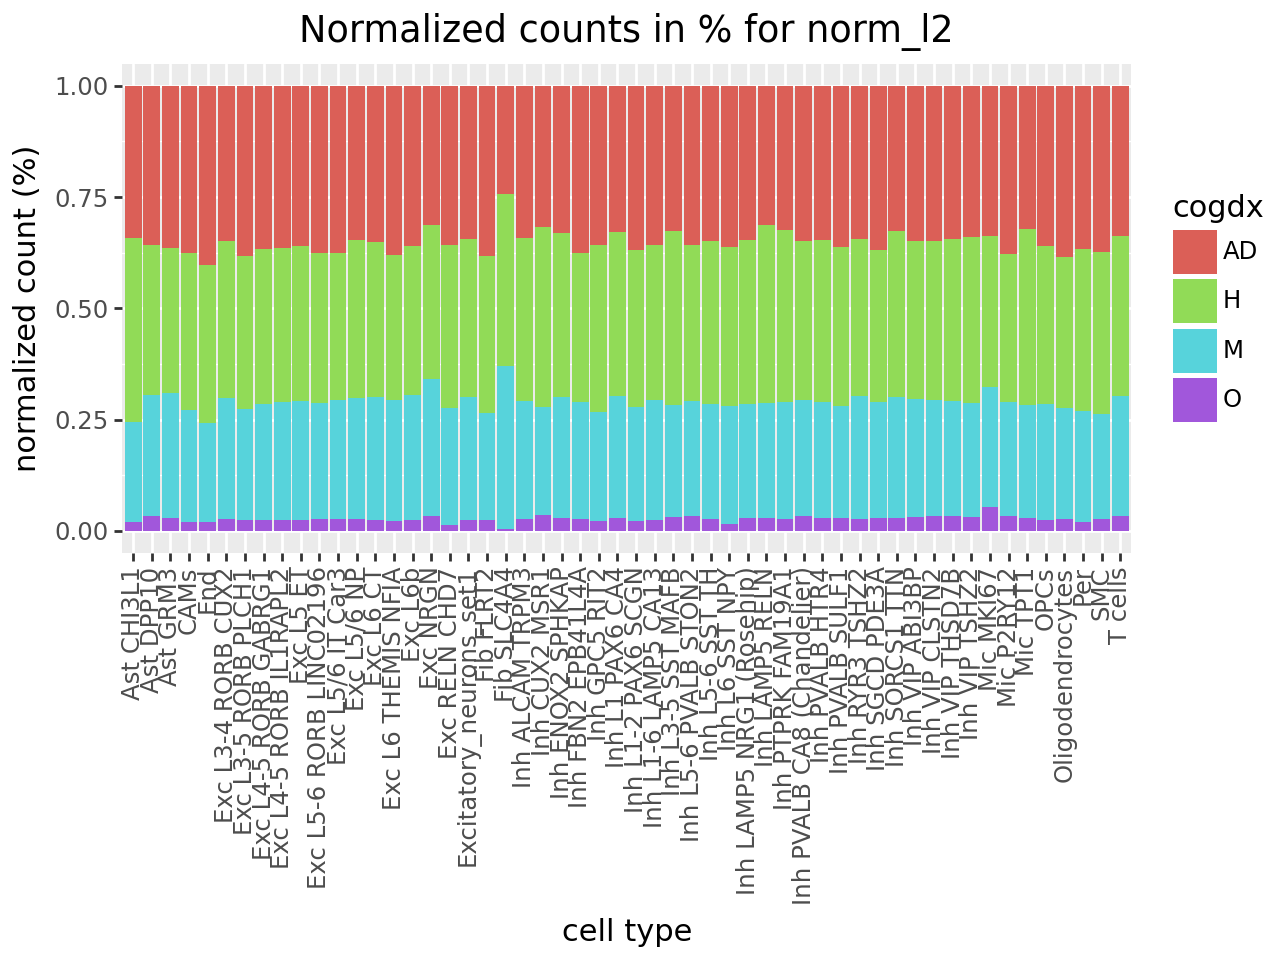

/home/jacob/Documents/BEP/bsc-thesis-scripts/plotmodules/norm_plots.py:114: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
/tmp/ipykernel_121452/3522506972.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


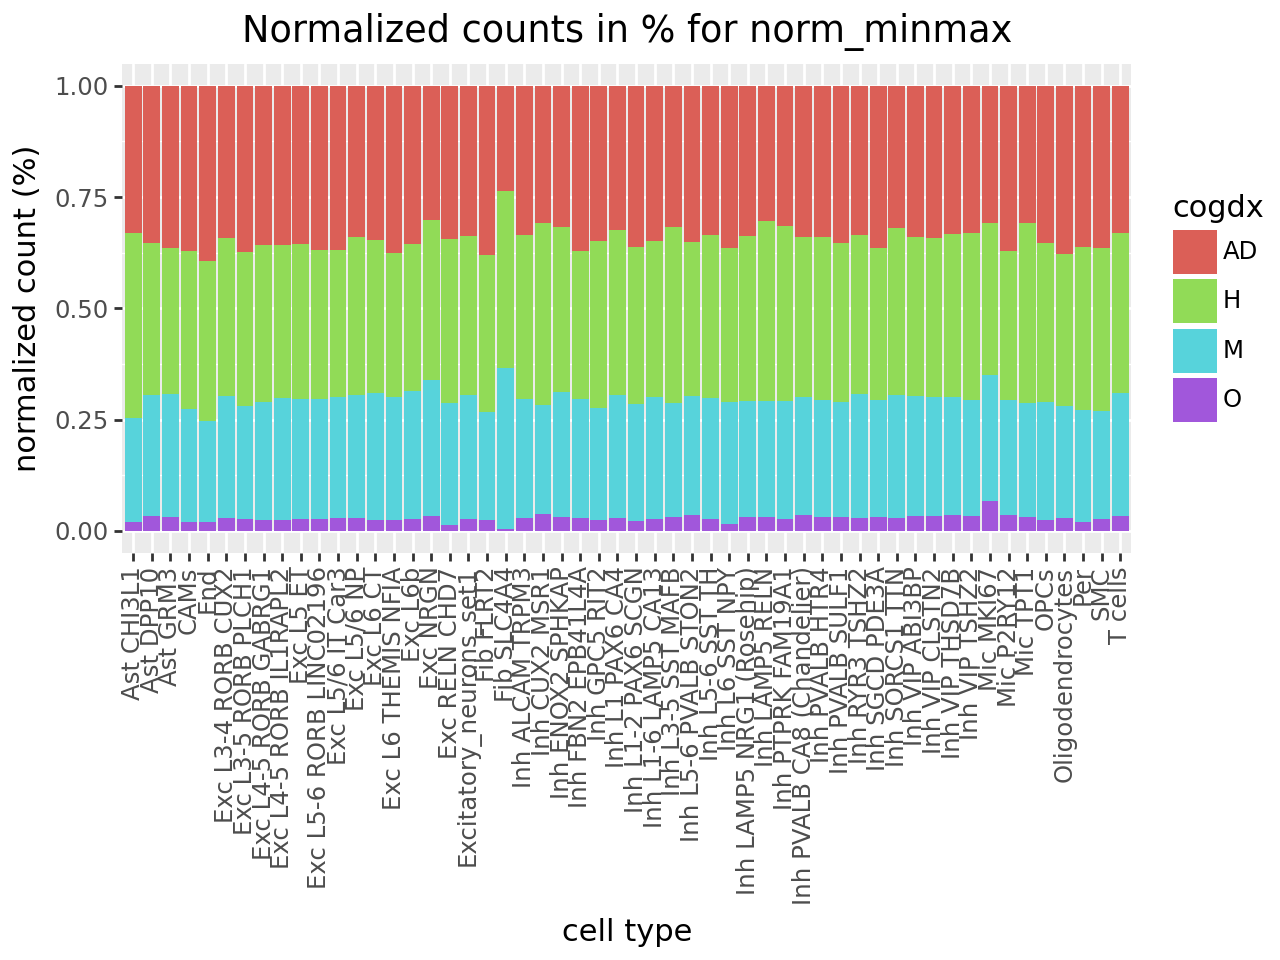

/home/jacob/Documents/BEP/bsc-thesis-scripts/plotmodules/norm_plots.py:114: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
/tmp/ipykernel_121452/3522506972.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


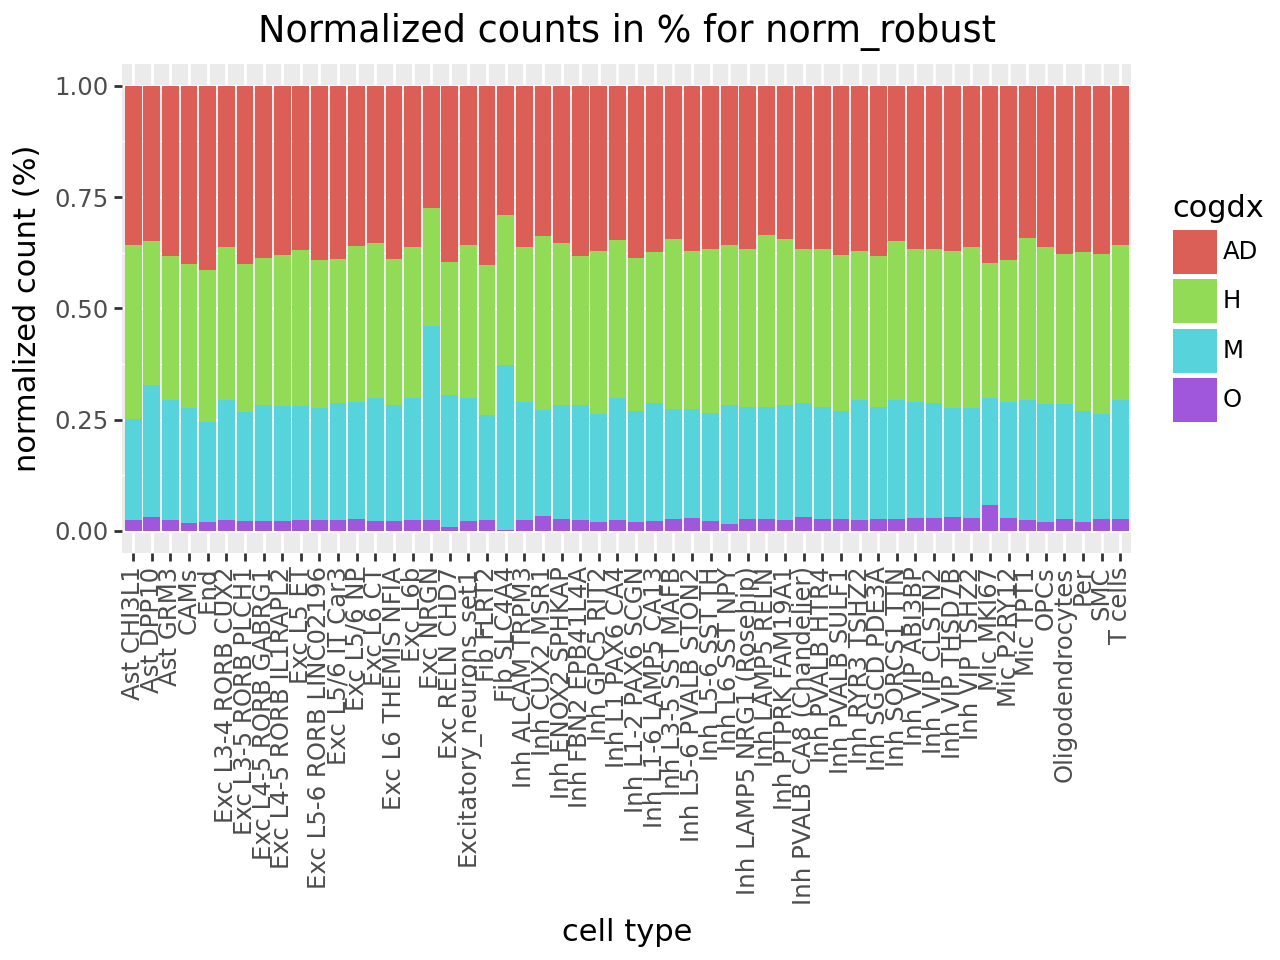

/home/jacob/Documents/BEP/bsc-thesis-scripts/plotmodules/norm_plots.py:114: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
/tmp/ipykernel_121452/3522506972.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


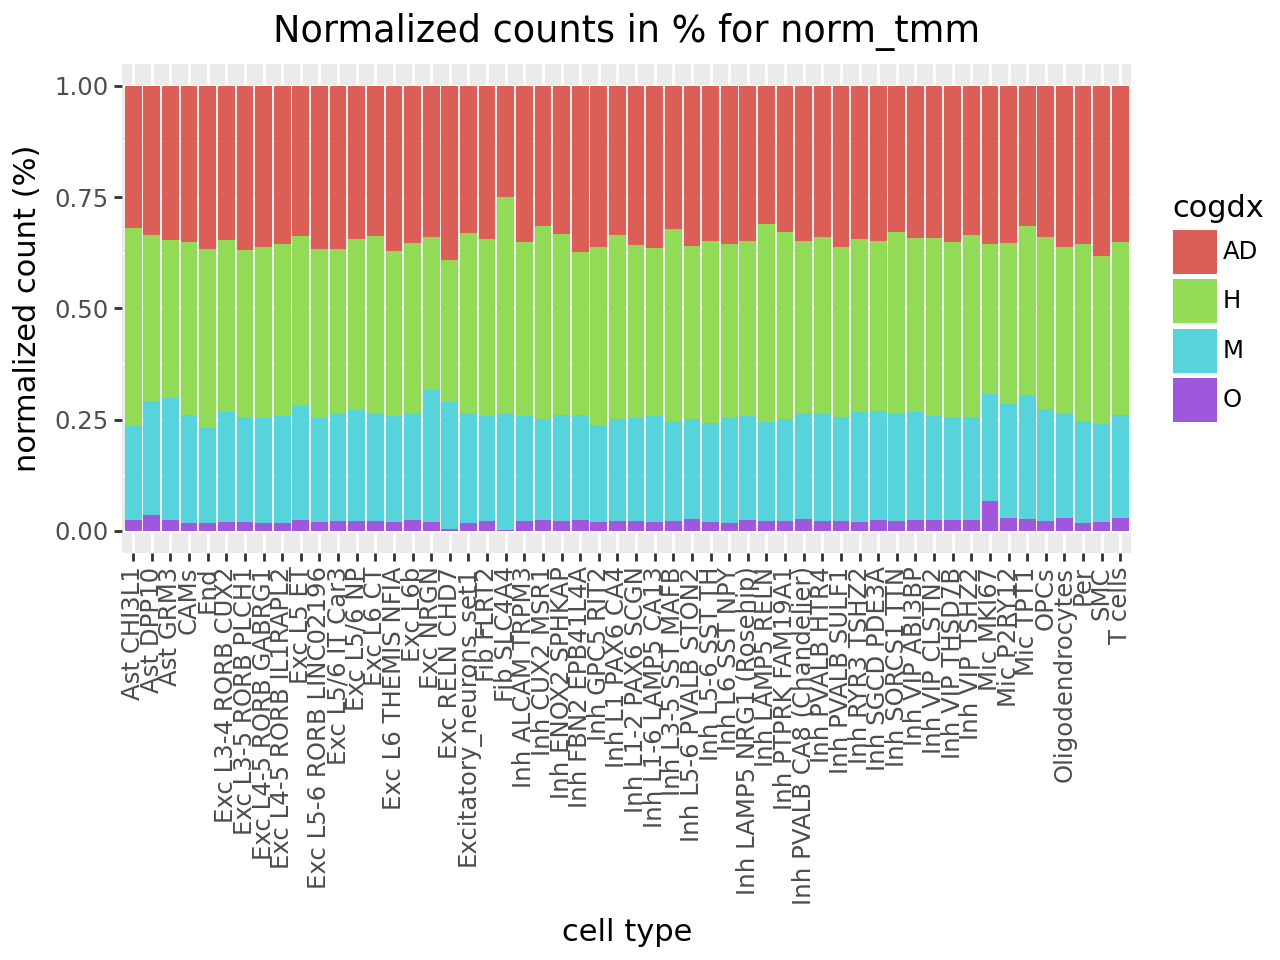

/home/jacob/Documents/BEP/bsc-thesis-scripts/plotmodules/norm_plots.py:114: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
/tmp/ipykernel_121452/3522506972.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


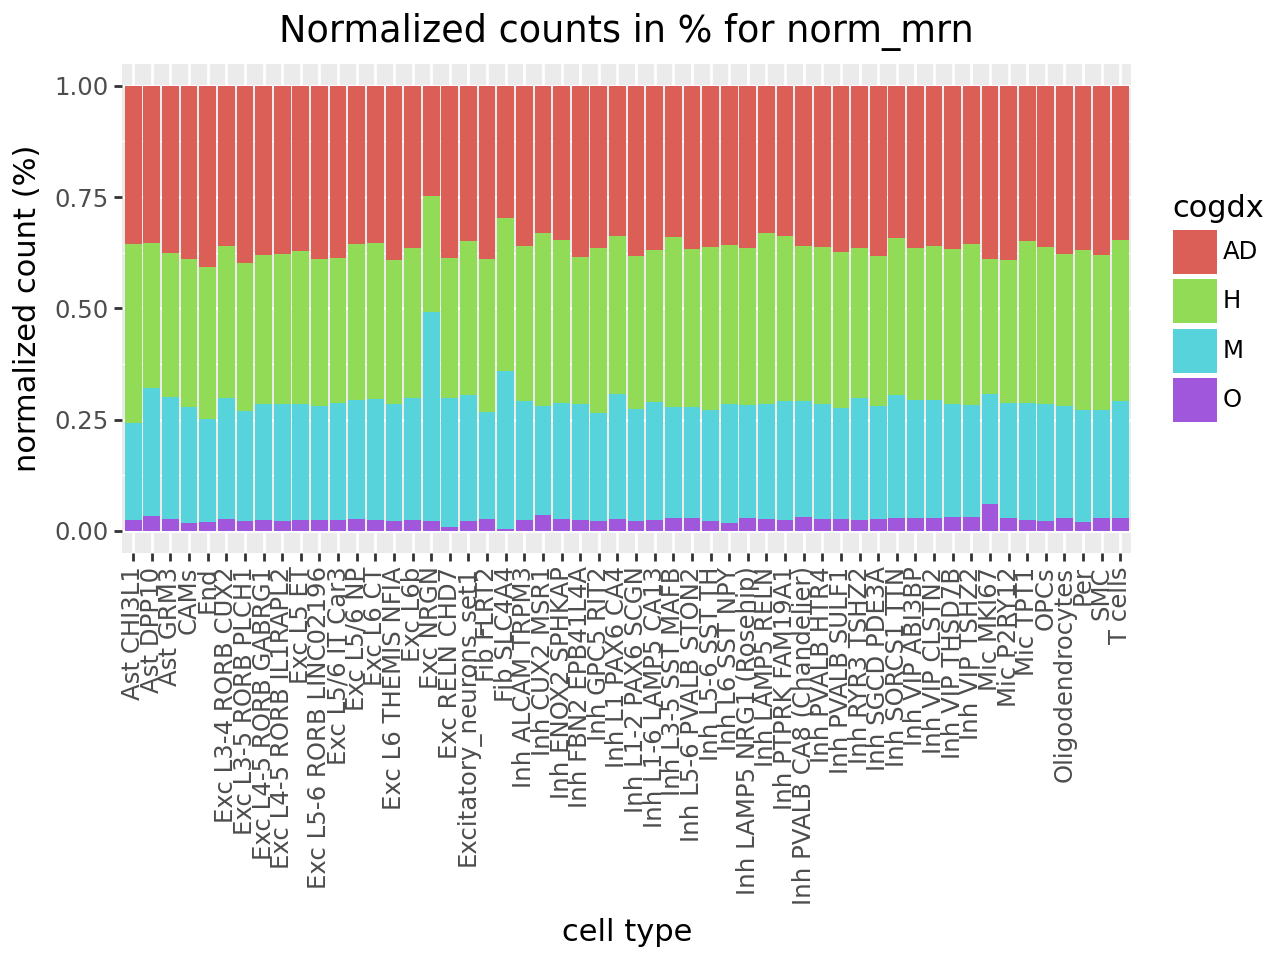

/home/jacob/Documents/BEP/bsc-thesis-scripts/plotmodules/norm_plots.py:114: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
/tmp/ipykernel_121452/3522506972.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


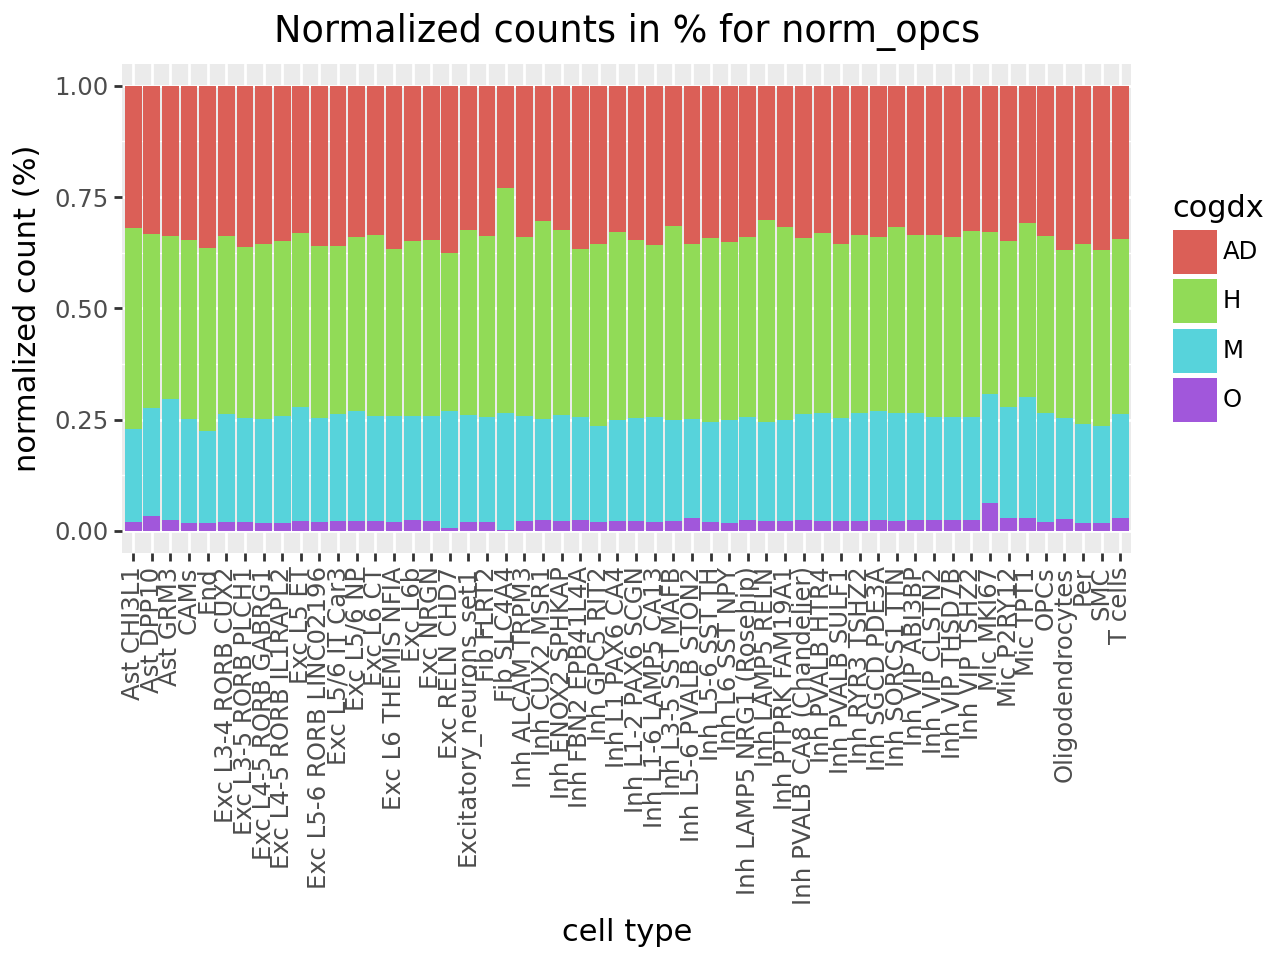

/home/jacob/Documents/BEP/bsc-thesis-scripts/plotmodules/norm_plots.py:114: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


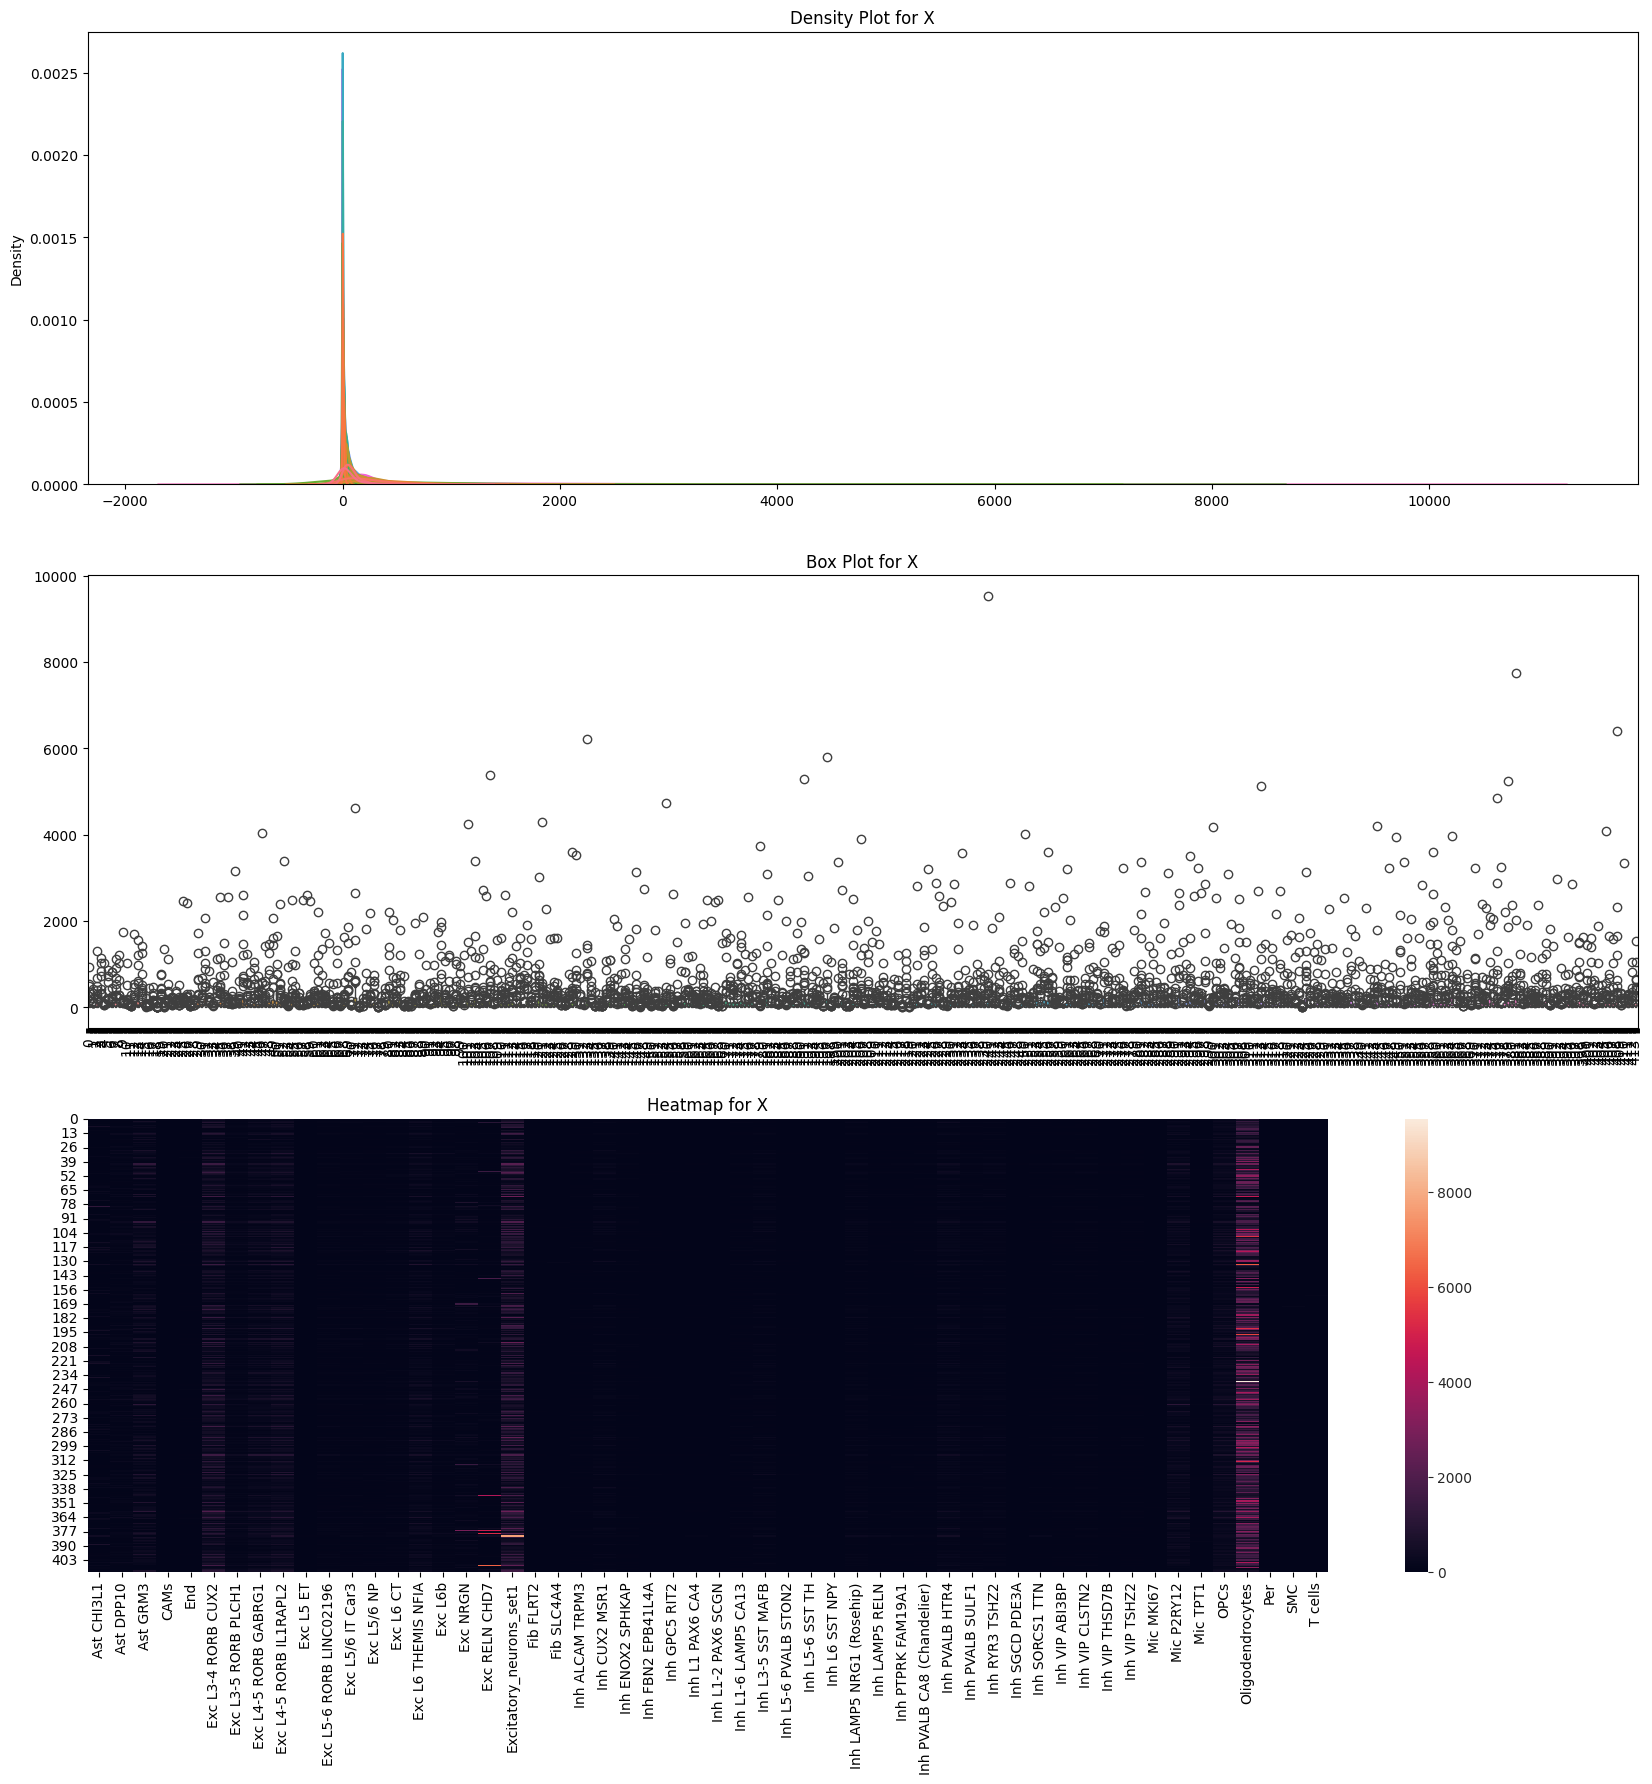

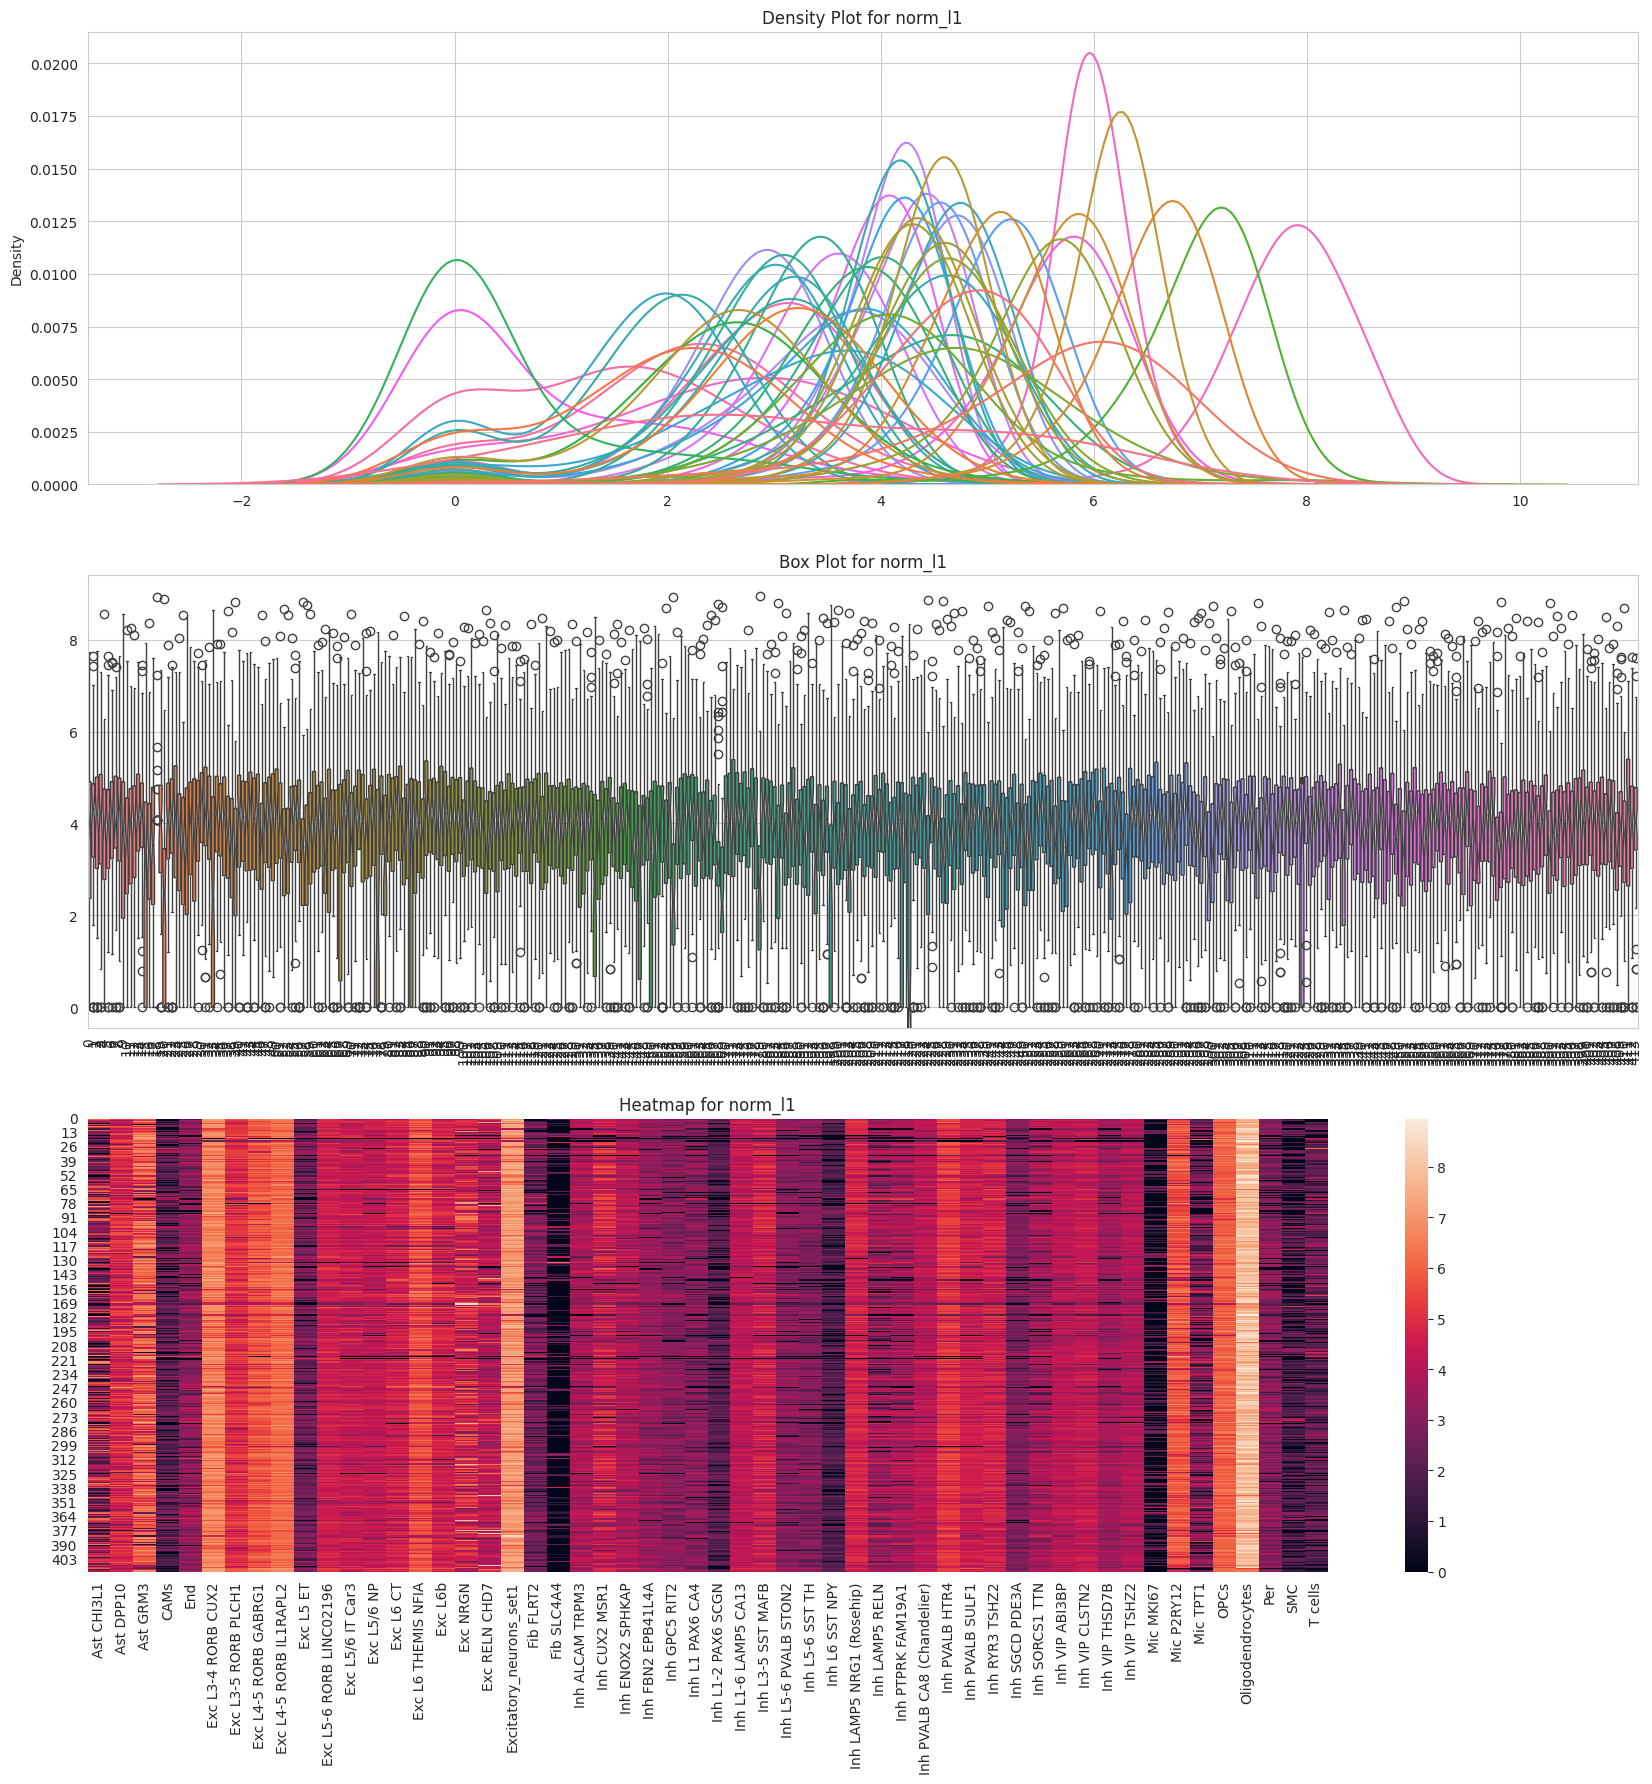

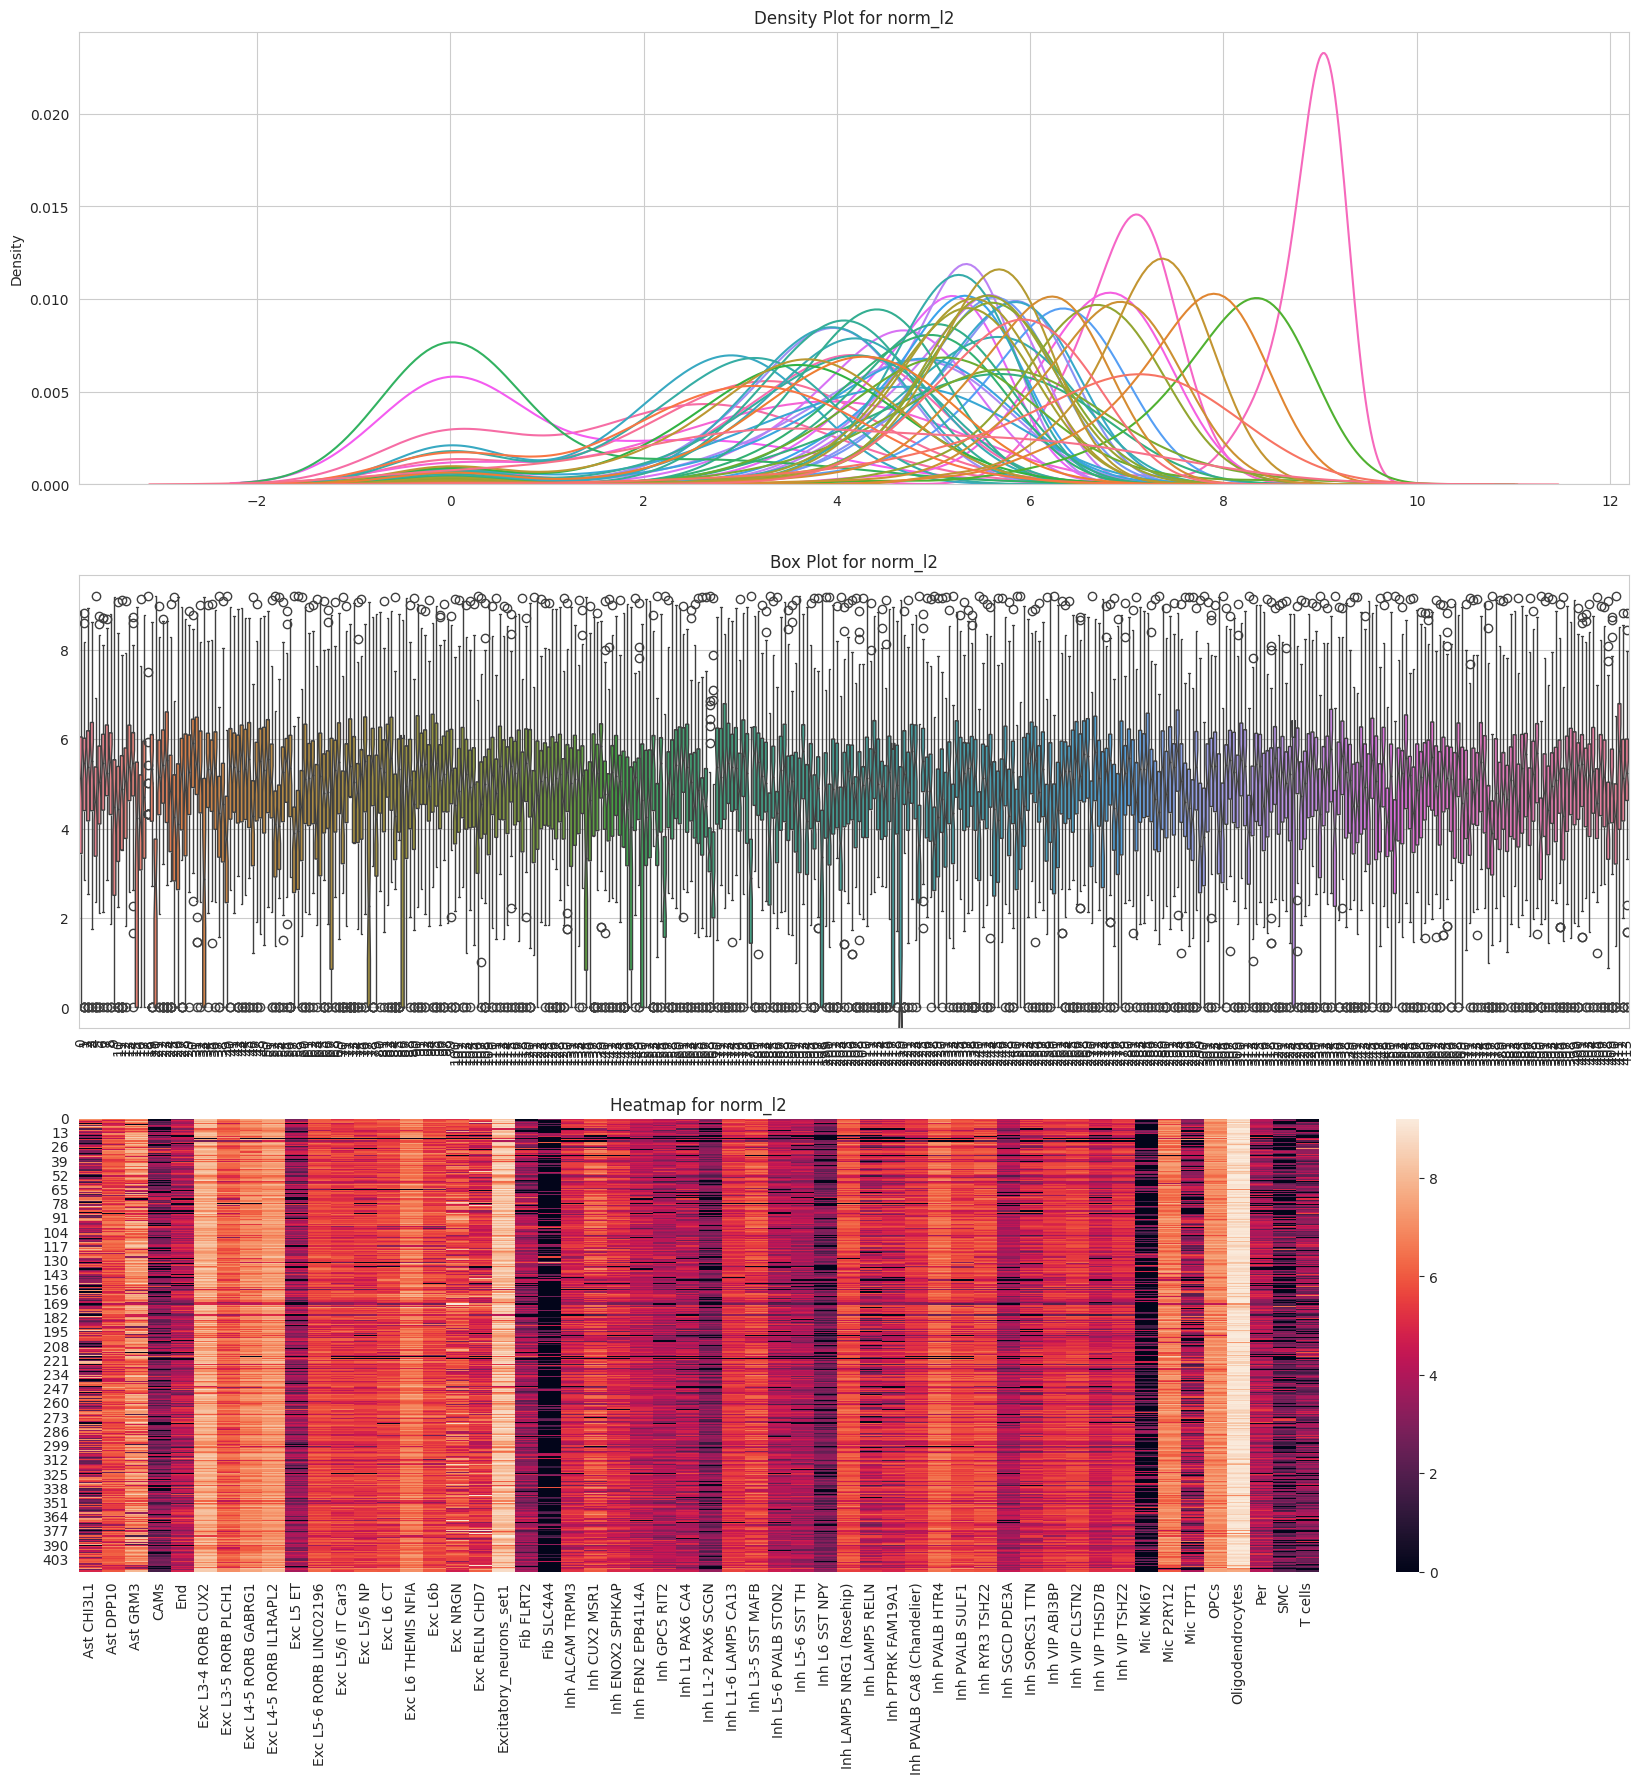

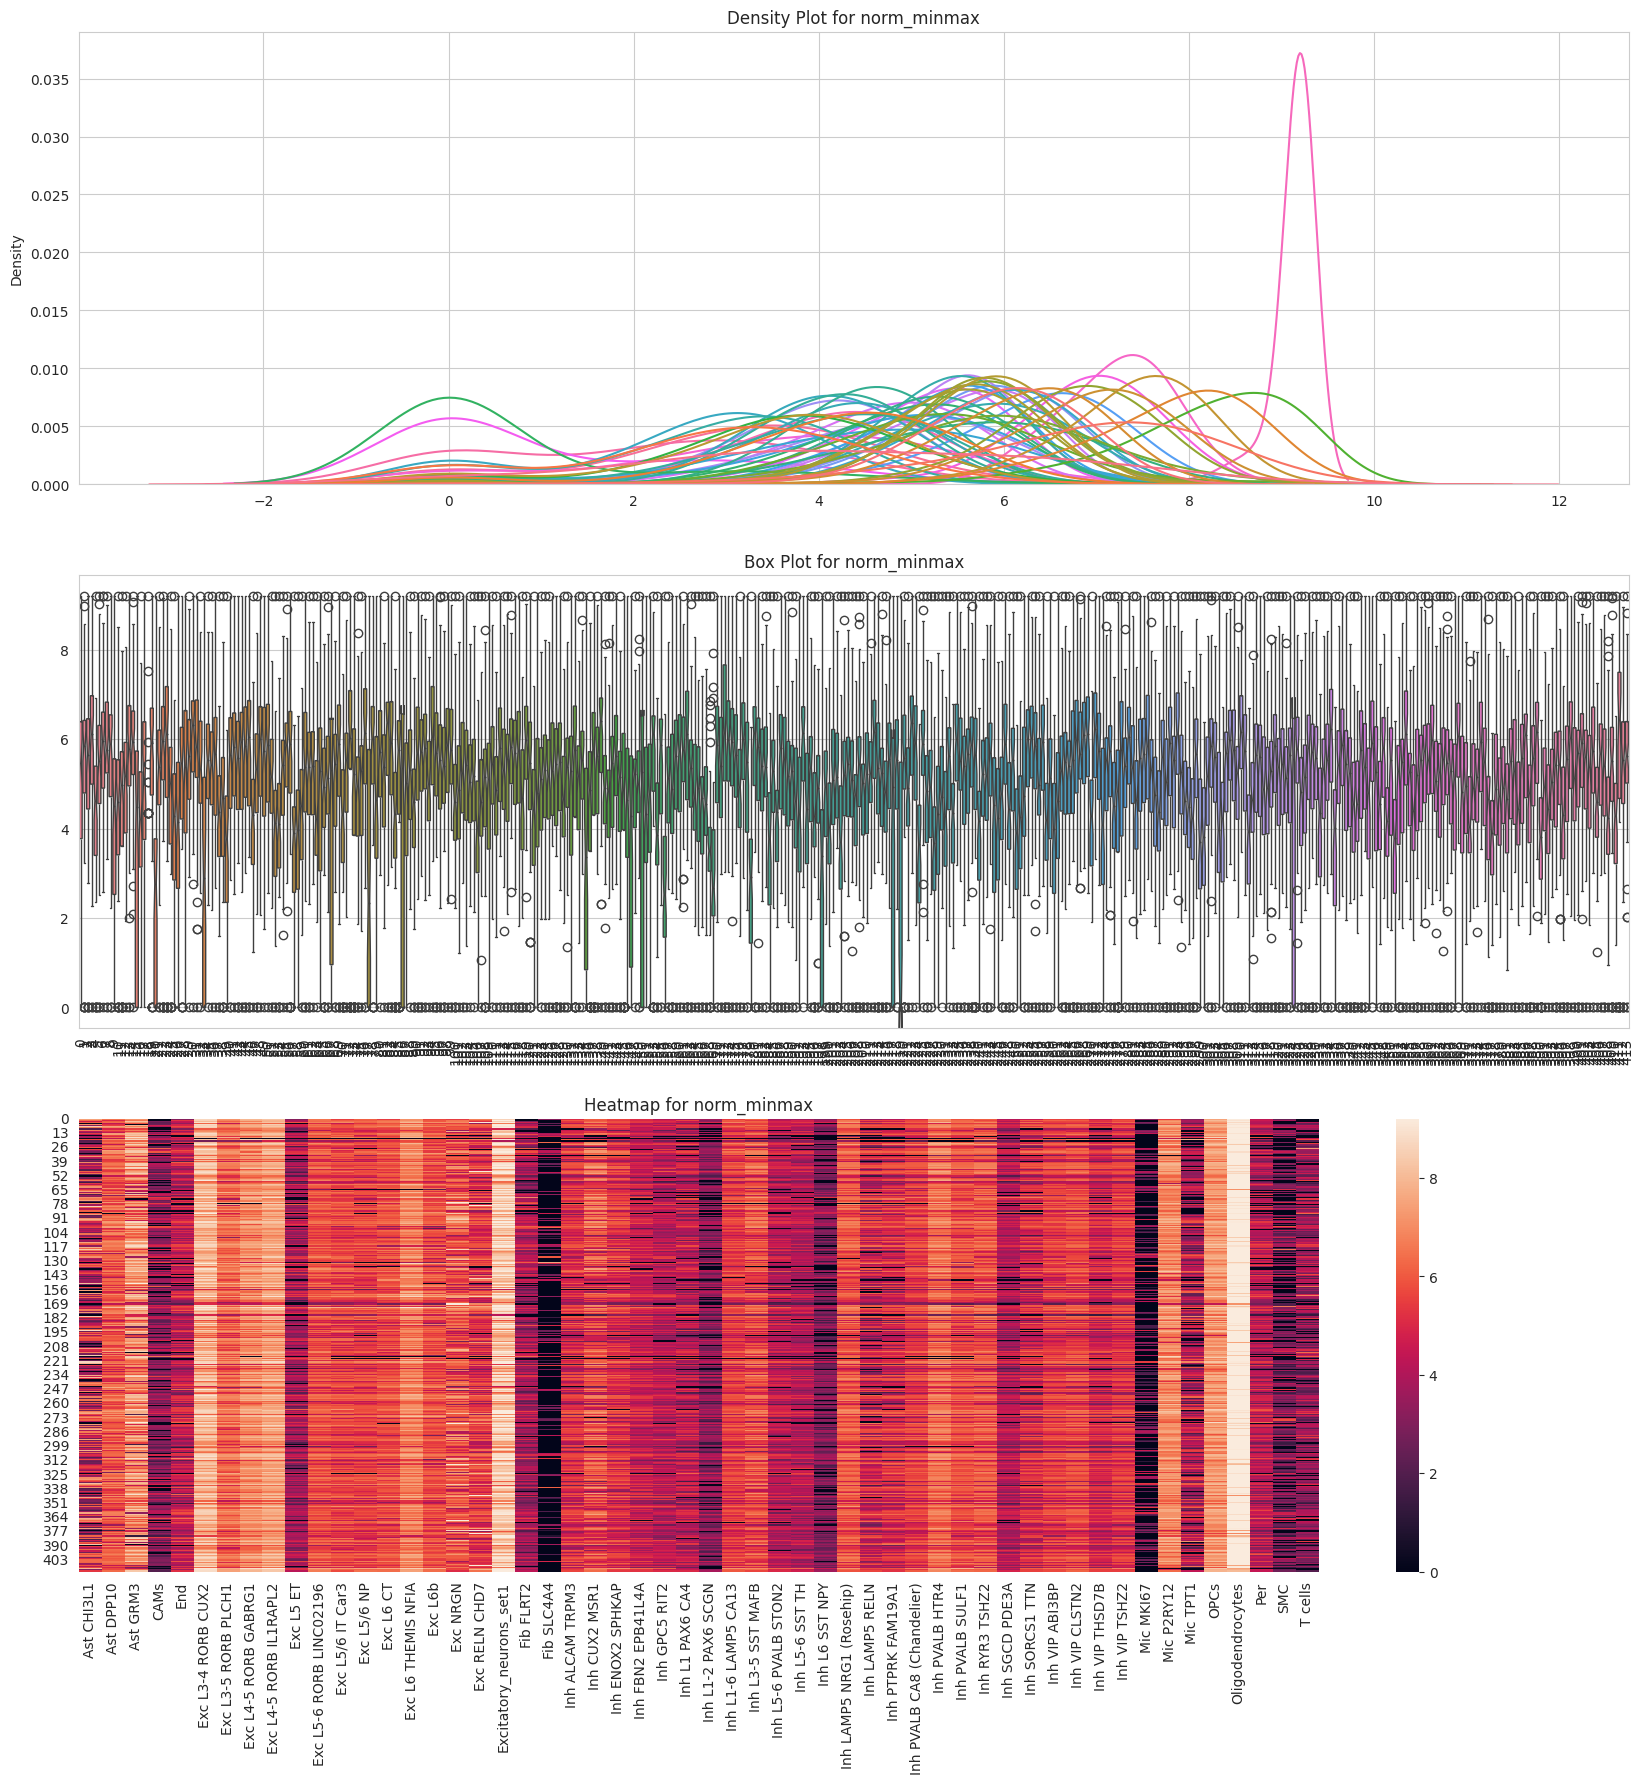

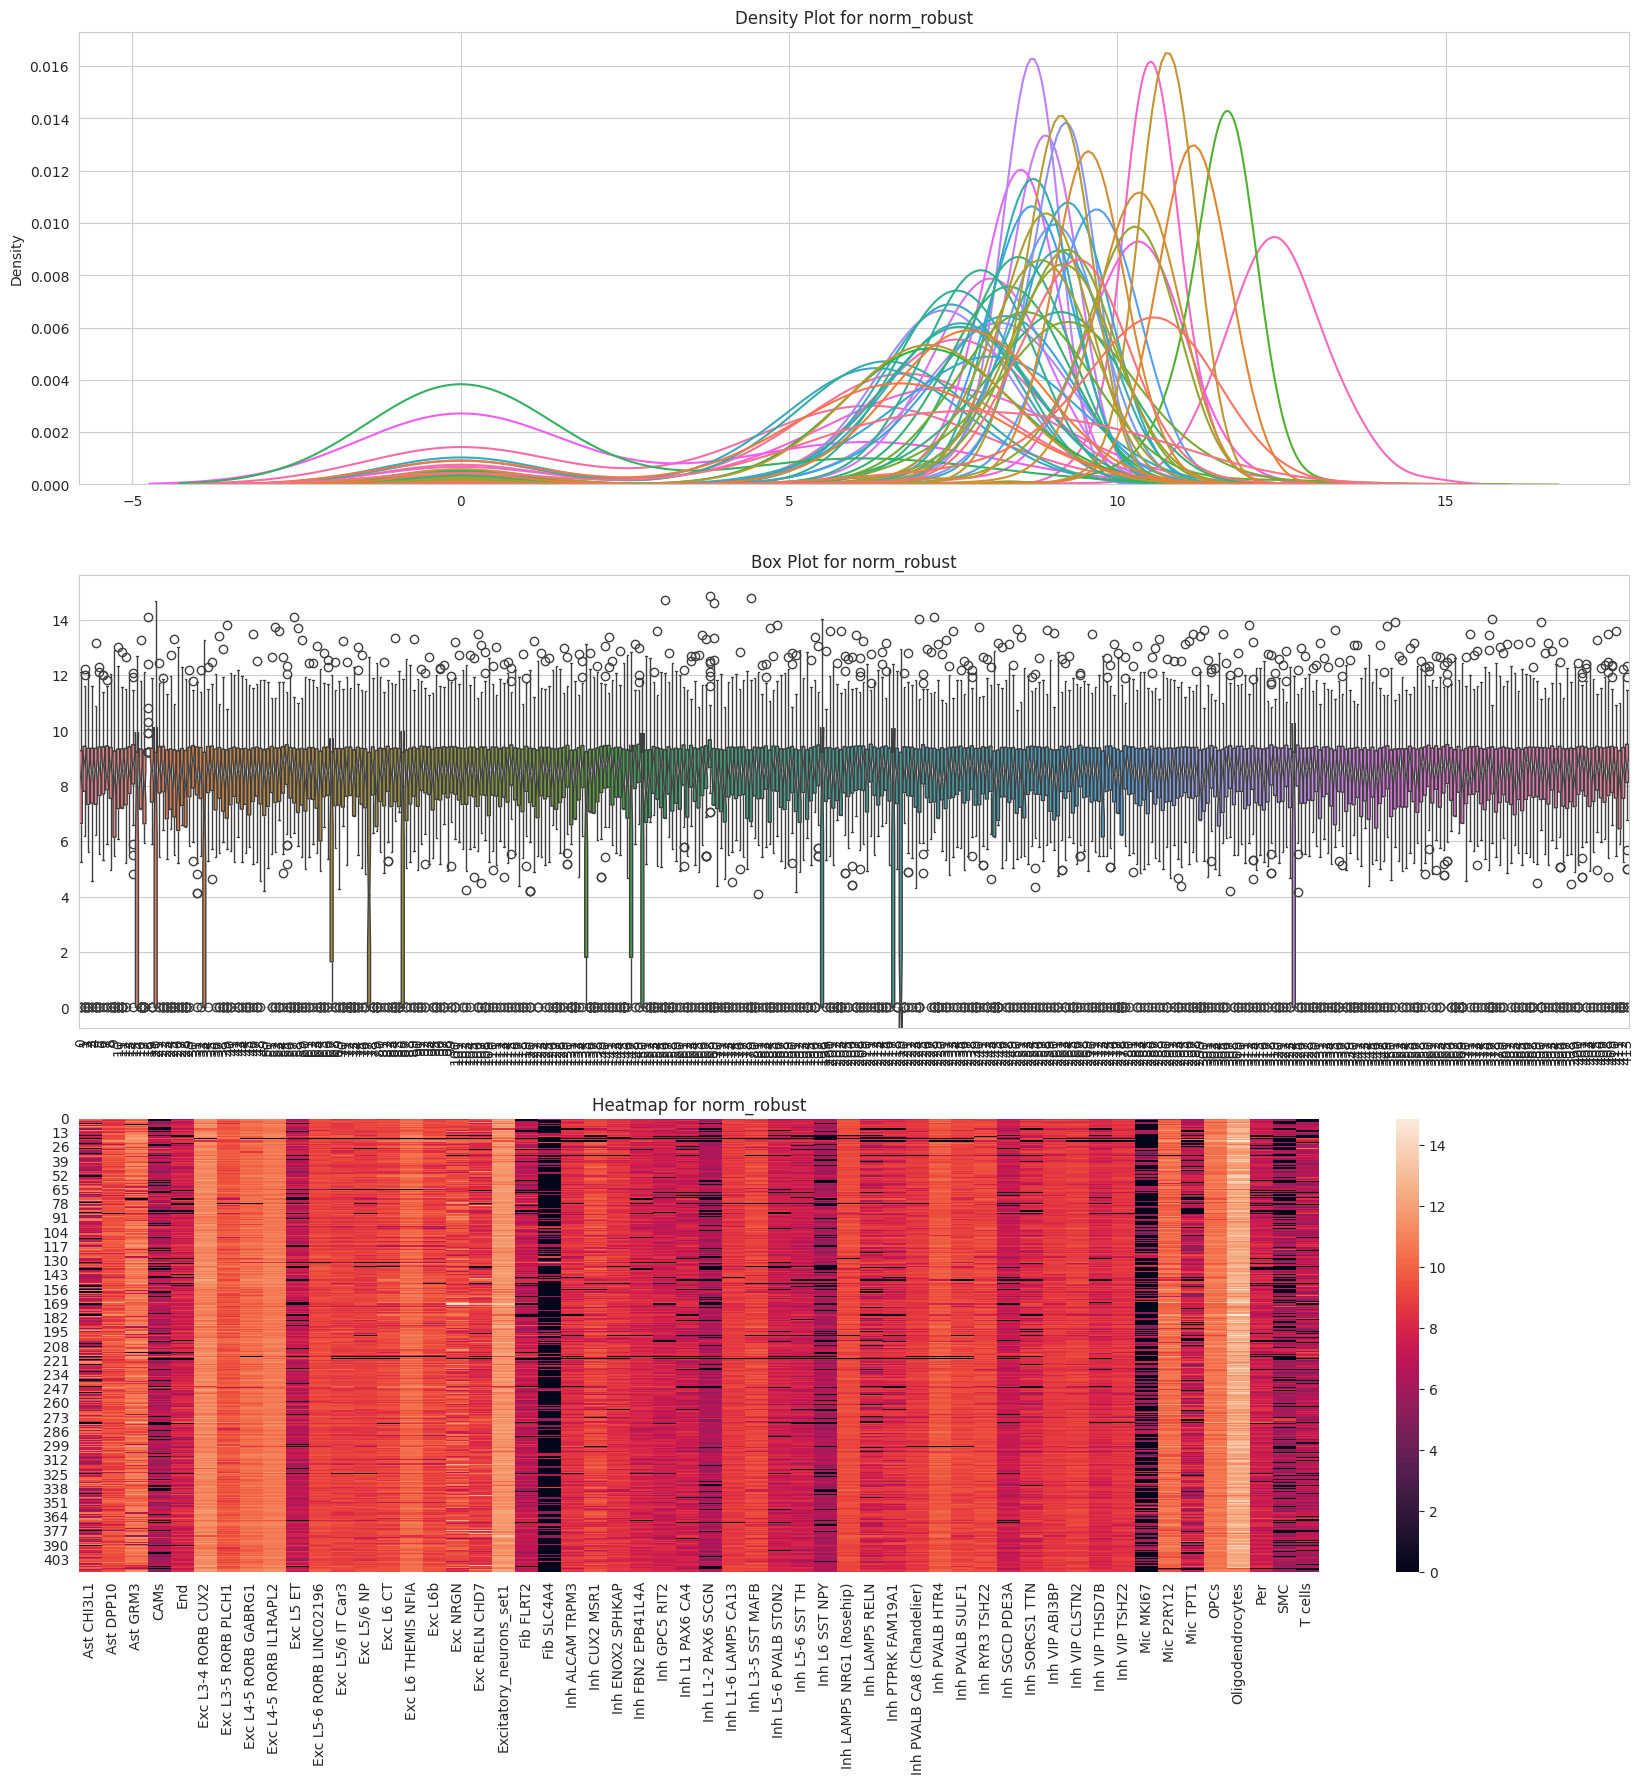

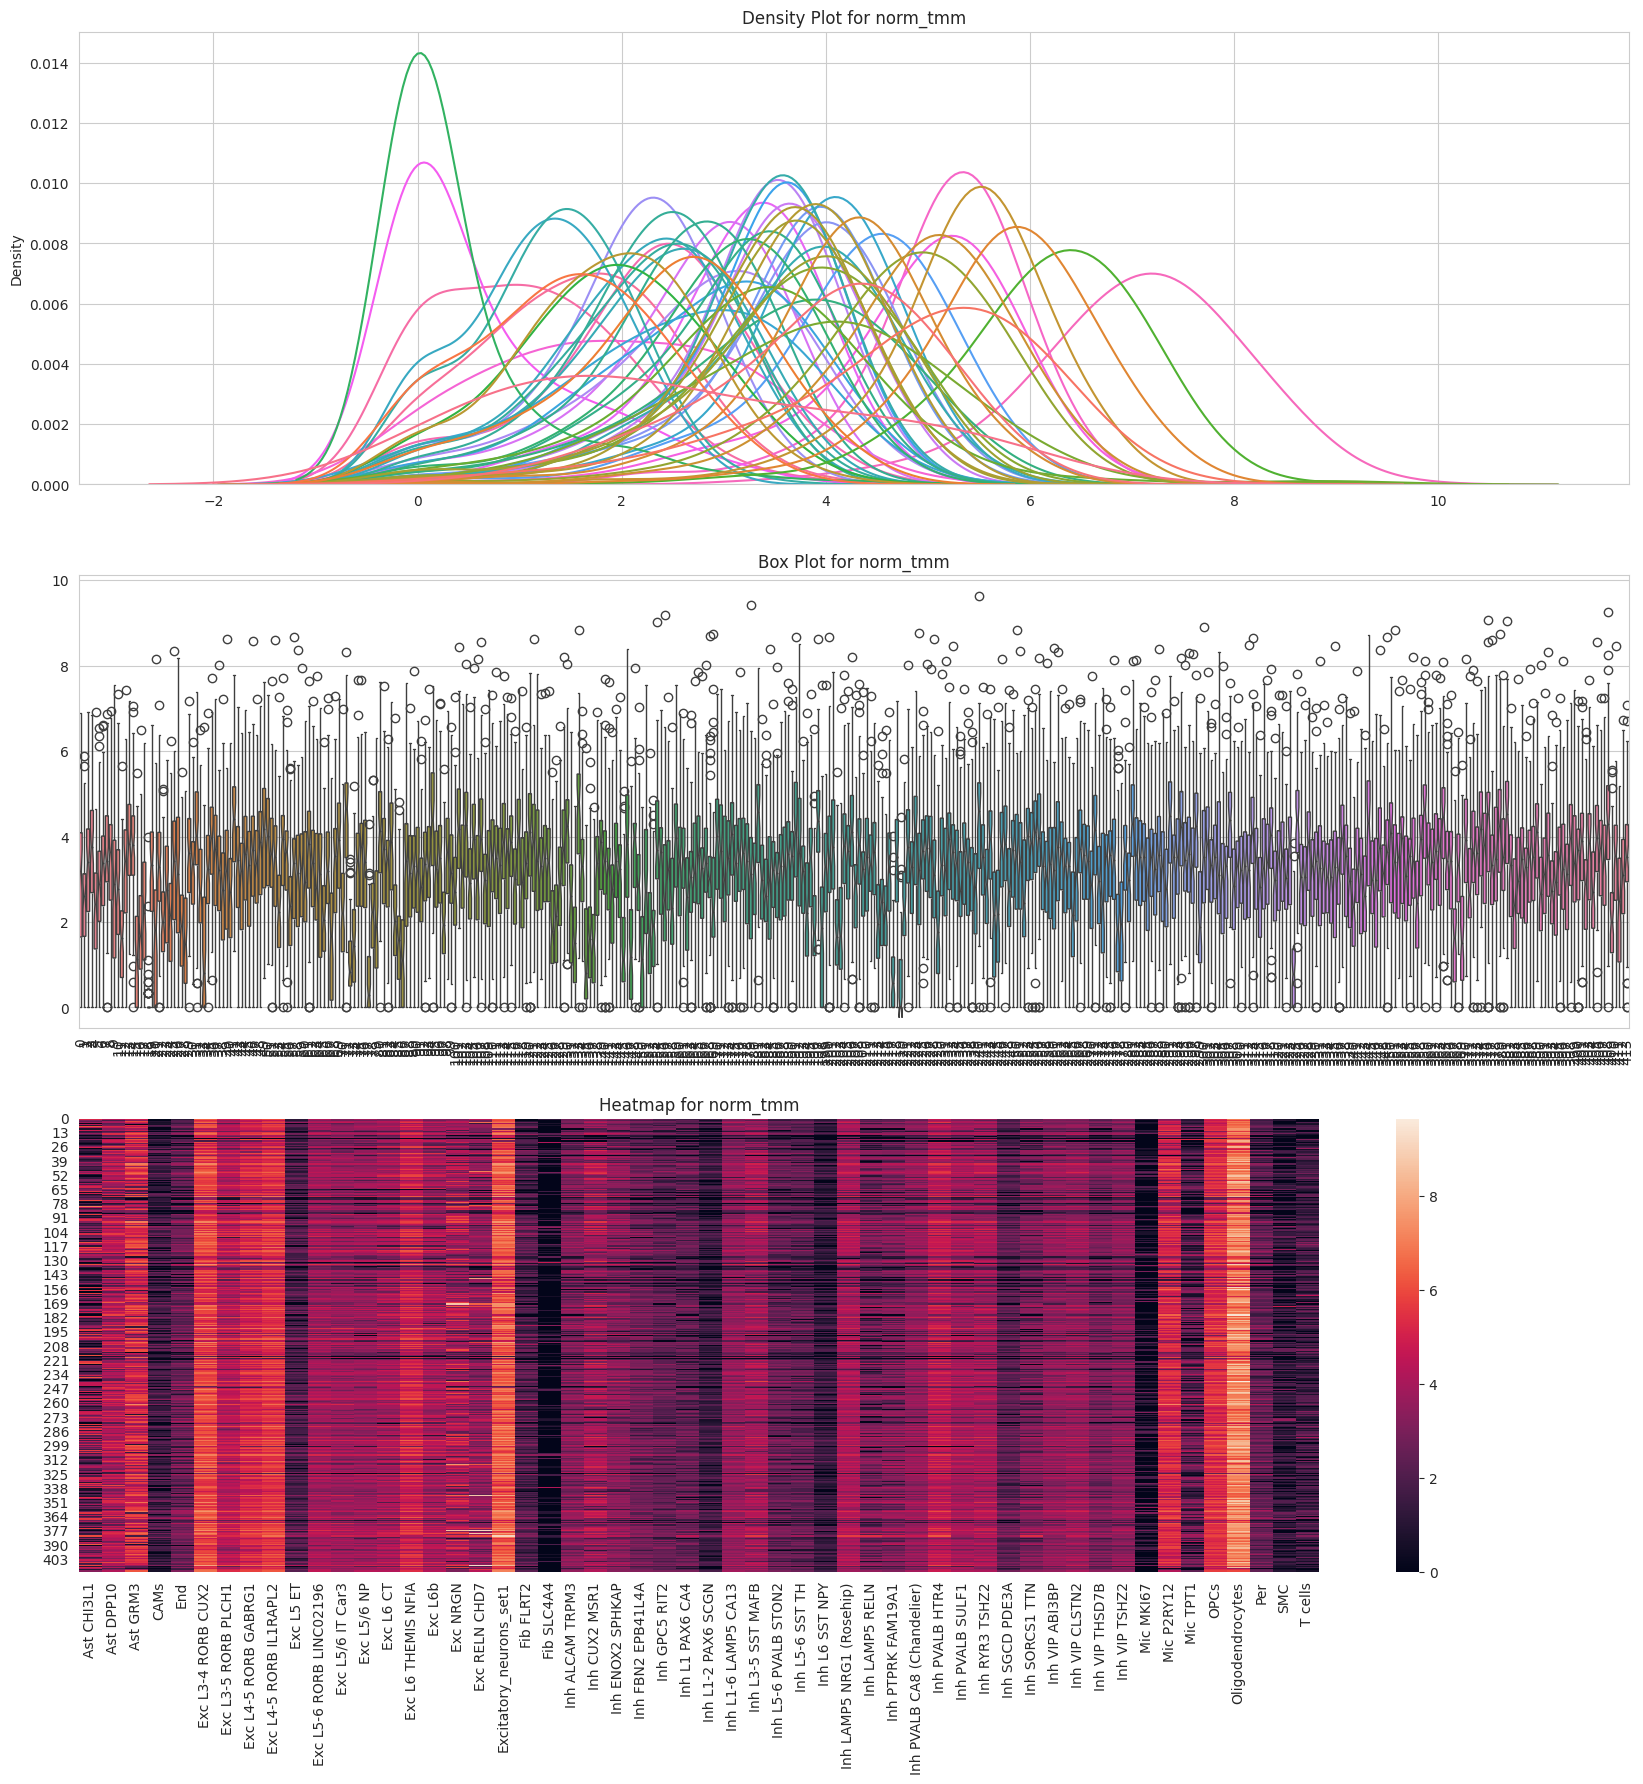

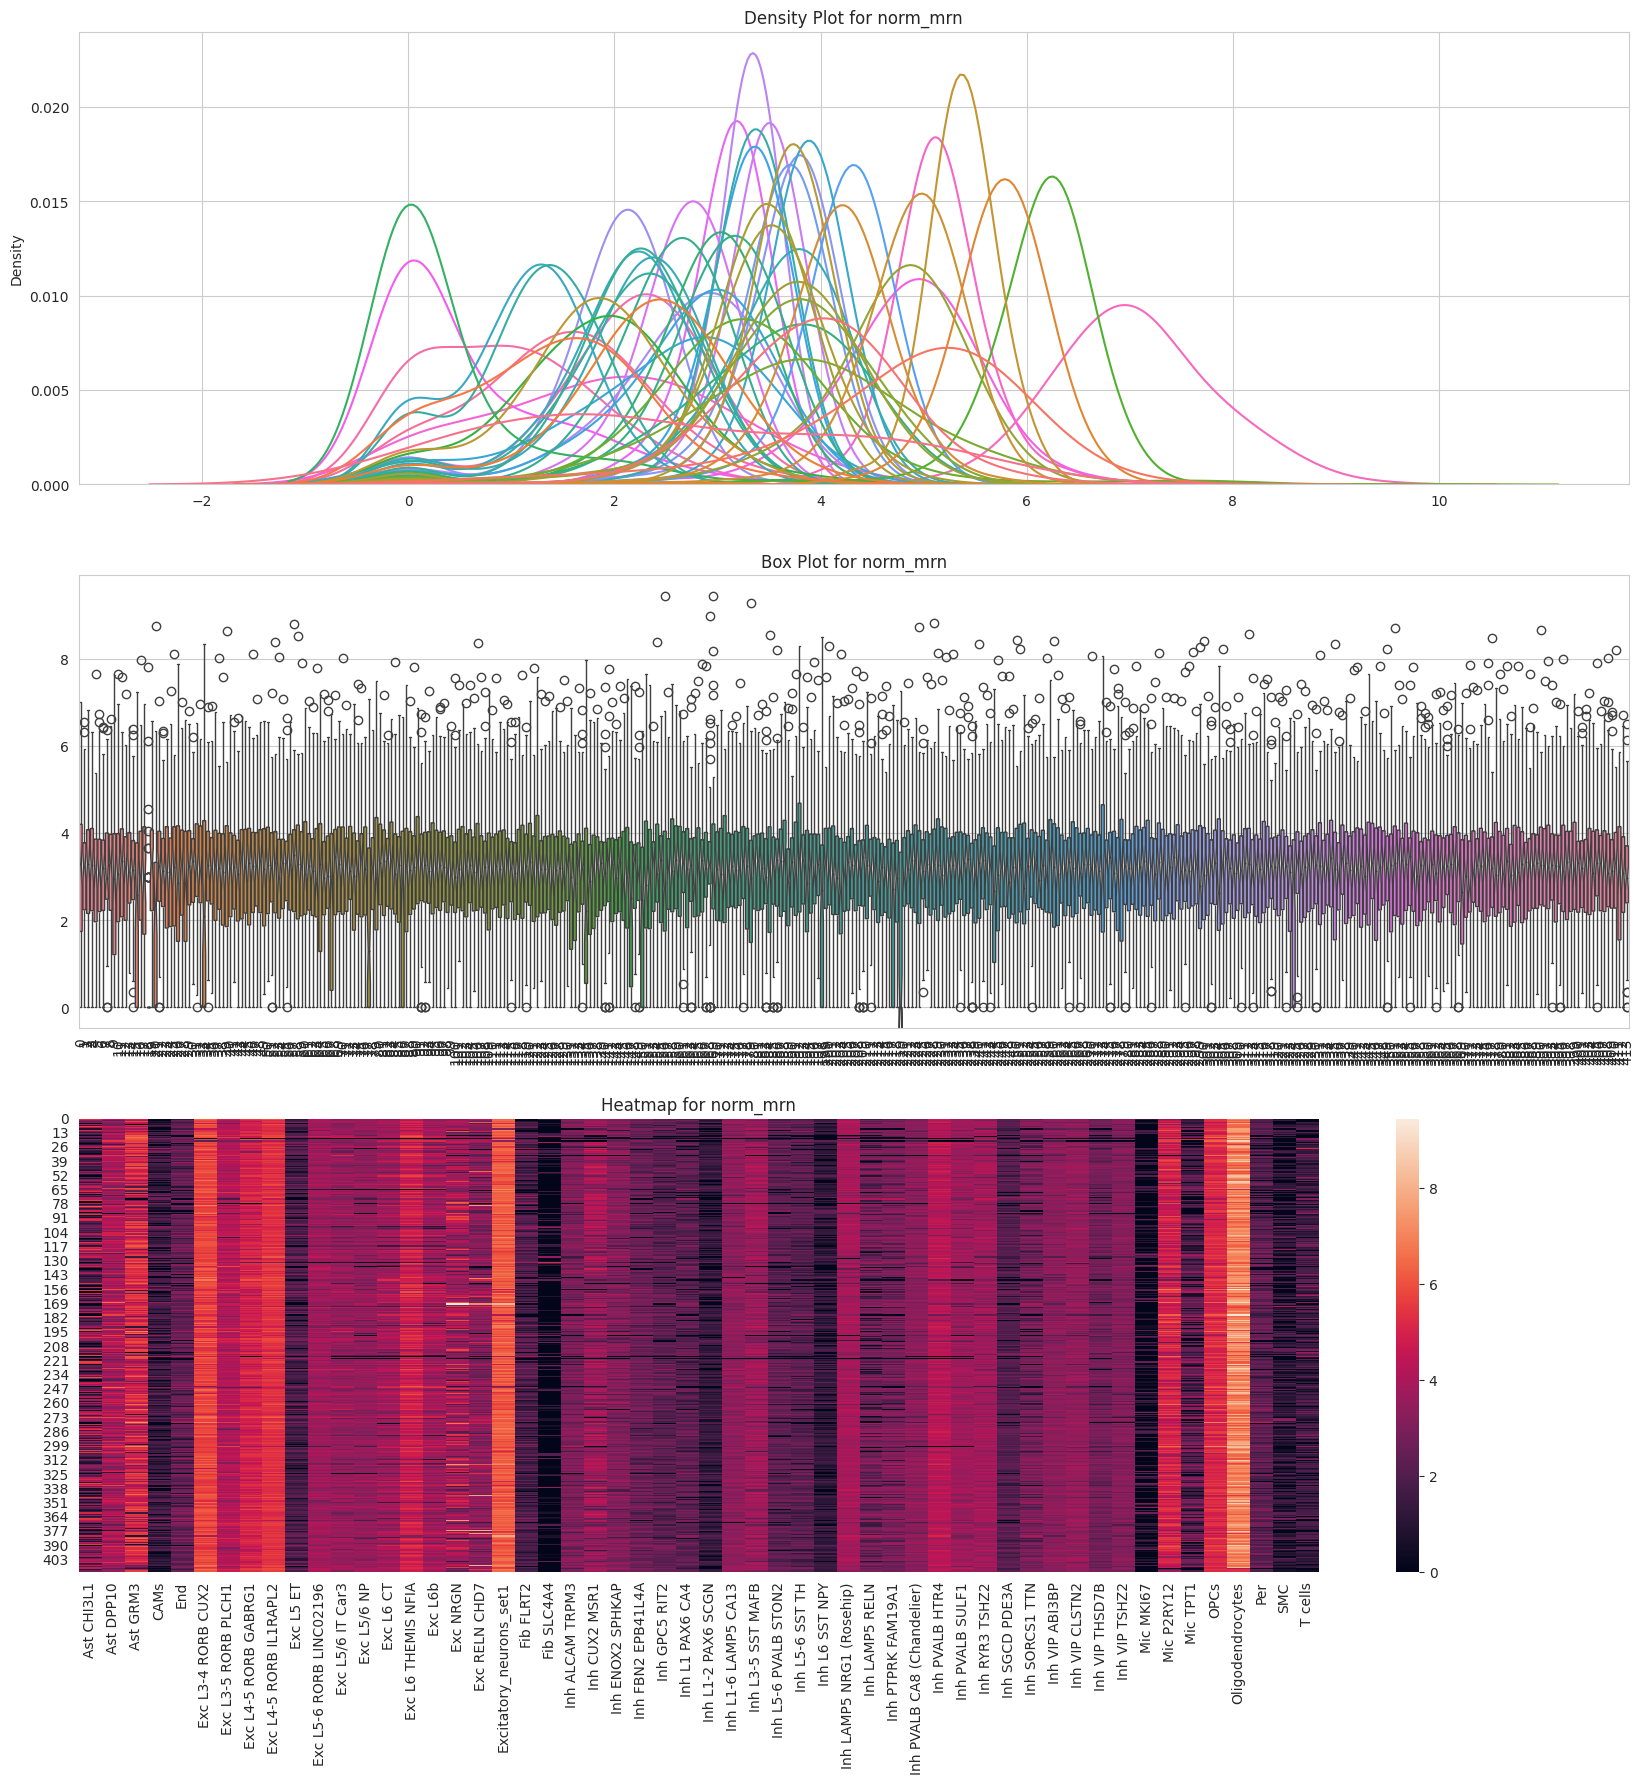

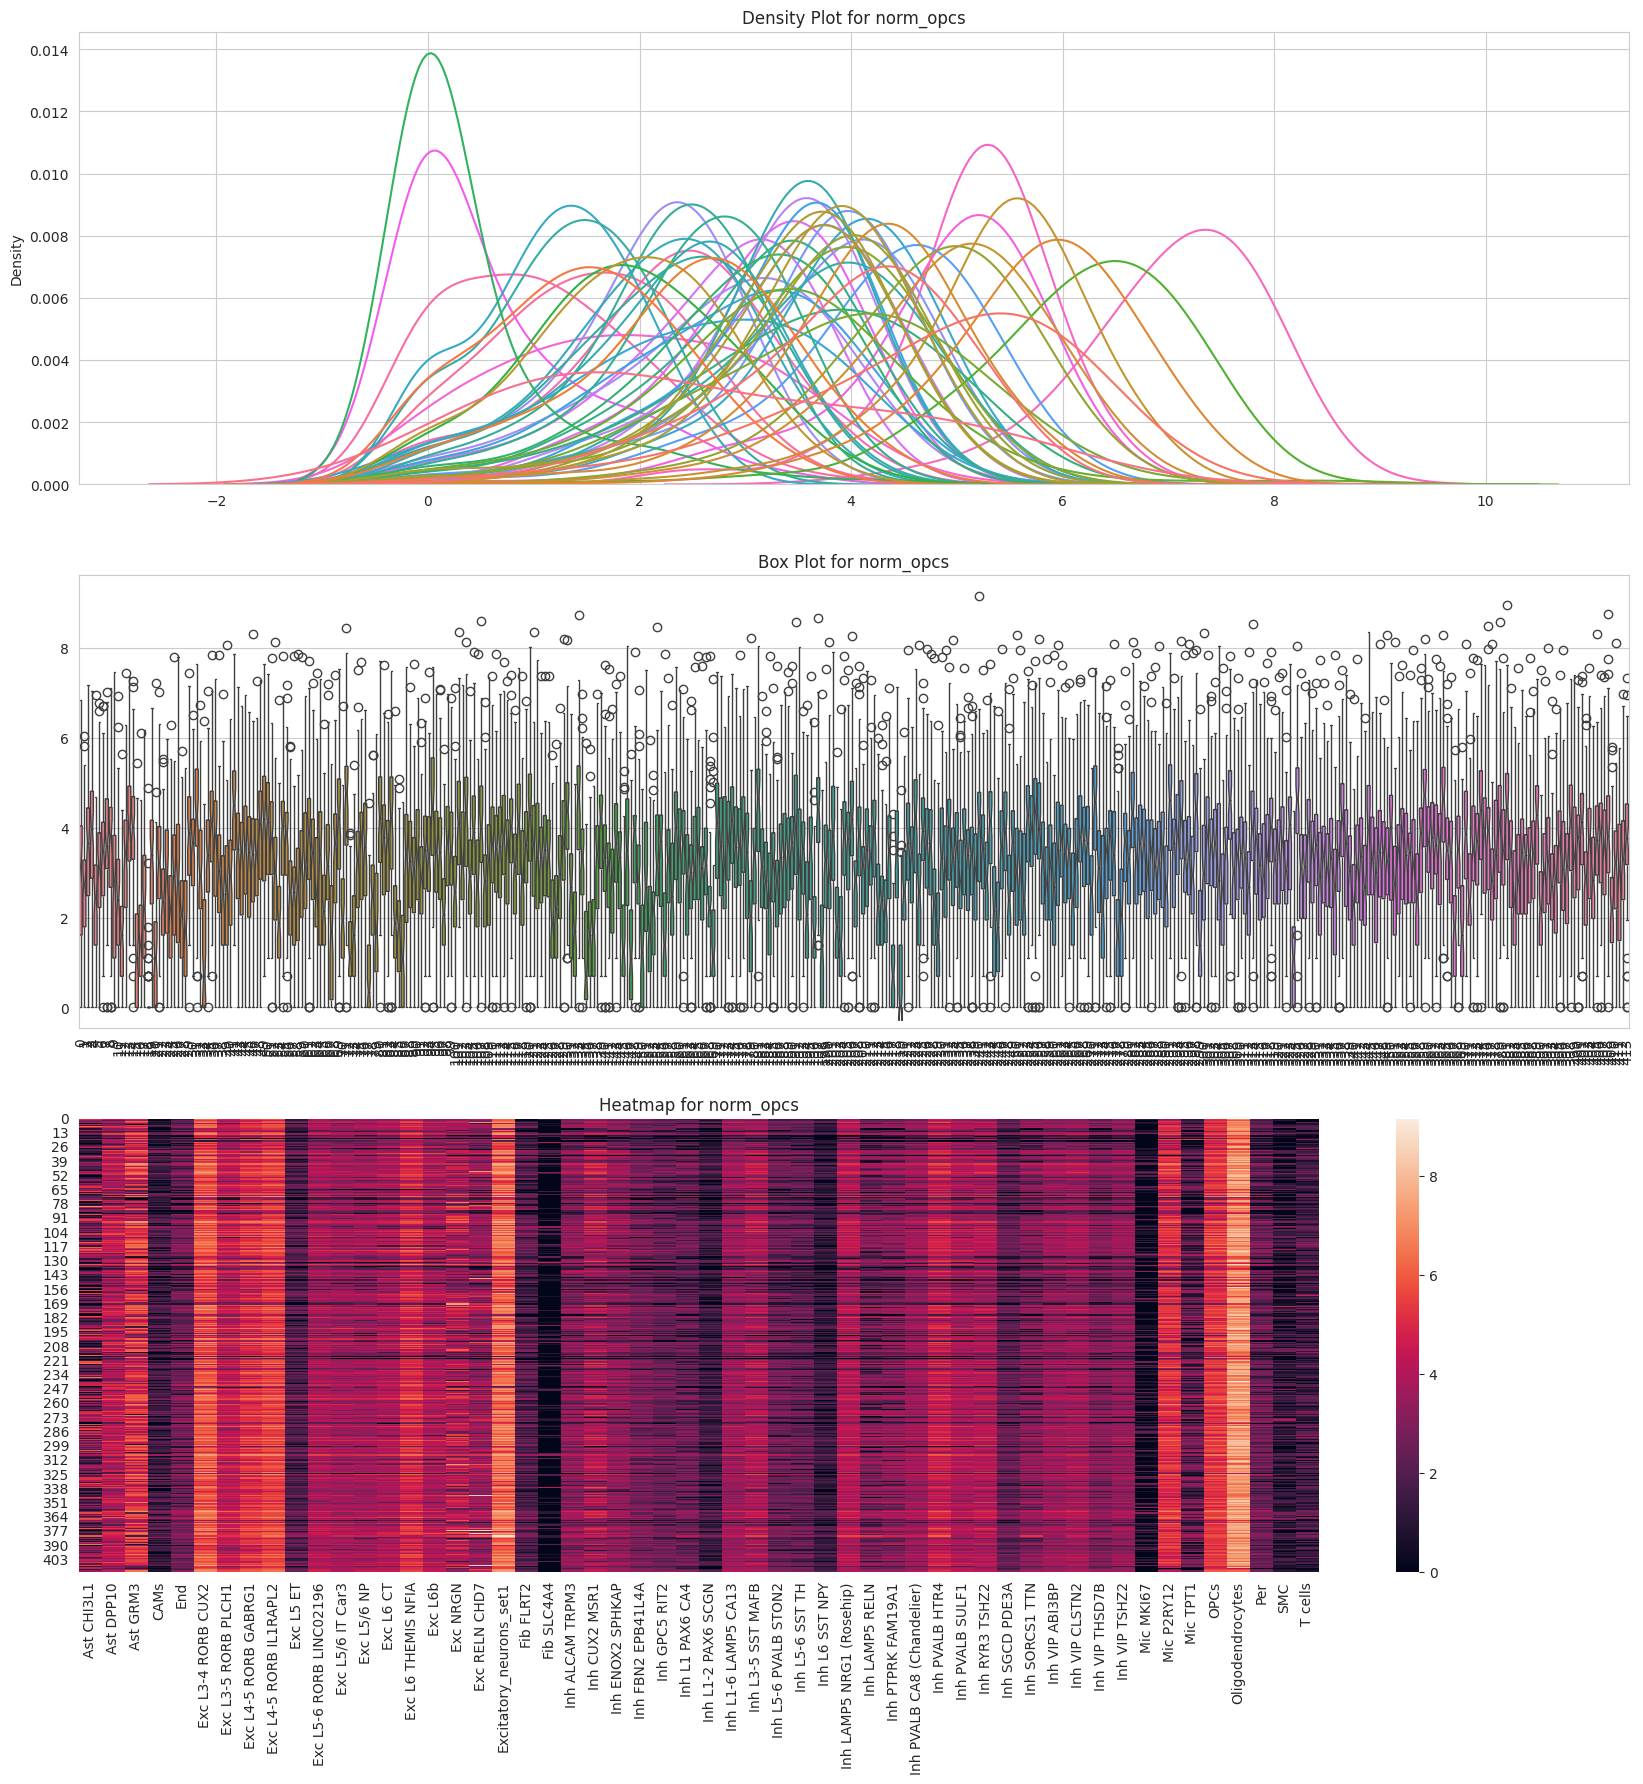

In [4]:
# Normalizations

from core.normalize import *
from plotmodules.norm_plots import *
from plotnine import aes, ggplot, geom_bar, ggtitle, element_text, theme, labs
from core.annotate import categorize_cogdx, COGDX_MAP

gg_df: pd.DataFrame

normalizations: list[tuple] = [(normalize_l1, 'norm_l1'),
                               (normalize_l2, 'norm_l2'),
                               (normalize_minmax, 'norm_minmax'), 
                               (normalize_robust, 'norm_robust'),
                               (normalize_tmm, 'norm_tmm'),
                               (normalize_mrn, 'norm_mrn'),
                               (normalize_by_reference, 'norm_opcs')]

generate_normalization_summary(ct_counts_metadata, 'X')

categorize_cogdx(ct_counts_metadata, COGDX_MAP)
#ct_counts_metadata = ct_counts_metadata[ct_counts_metadata.obs['cogdx_class'].isin(['H', 'AD']), :]
ct_counts_metadata.obs['cogdx_classcodes'] = ct_counts_metadata.obs['cogdx_class'].cat.codes
for func, layer in normalizations:
    func(ct_counts_metadata, layer, reference='OPCs')
    gg_df = pd.DataFrame(func(ct_counts_metadata, transformation_func=None, inplace=False, reference='OPCs').layers['norm'], 
                         columns=ct_counts_metadata.var_names.tolist(), index=ct_counts_metadata.obs_names)
    gg_df['cogdx'] = ct_counts_metadata.obs['cogdx_class']
    gg_df = gg_df.melt(id_vars=['cogdx']).groupby(['cogdx', 'variable'], as_index=False).sum()
    barplot = ggplot(gg_df, aes(x='variable', y='value', fill='cogdx')) +\
        geom_bar(position='fill', stat='identity') +\
        ggtitle('Normalized counts in % for ' + layer) +\
        theme(axis_text_x=element_text(rotation=90)) +\
        labs(y='normalized count (%)', x='cell type')
    display(barplot)
    generate_normalization_summary(ct_counts_metadata, layer)
    #generate_clustermap(ct_counts_metadata, layer, 'cogdx_classcodes')